In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c252b097-ded4-f931-a80d-a9def02b7b14)


# HandwrittenCalc

In [3]:
!pip install imutils

import numpy as np 
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.contours import sort_contours
import imutils

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [5]:
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

In [ ]:
# unzip_data("All data (Compressed).zip")

### 데이터 확인

In [67]:
import pathlib
import numpy as np

data_dir = pathlib.Path("totalDataset01")
class_names = np.array(
    sorted(
        [item.name for item in data_dir.glob("*")]
    )
)

print(class_names)

['%' '*' '+' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [71]:
import os

for dirpath, dirnames, filenames in os.walk("totalDataset01"):
    print(f"{len(dirnames)}개의 디렉토리가 있으며, '{dirpath}'에는 {len(filenames)}개의 이미지가 있다.")

14개의 디렉토리가 있으며, 'totalDataset01'에는 0개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/1'에는 20947개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/4'에는 22216개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/7'에는 20279개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/-'에는 21962개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/3'에는 22303개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/8'에는 21191개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/5'에는 21124개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/6'에는 21182개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/+'에는 22682개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/2'에는 20971개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/0'에는 20845개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/9'에는 20995개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/*'에는 20899개의 이미지가 있다.
0개의 디렉토리가 있으며, 'totalDataset01/%'에는 24783개의 이미지가 있다.


## 데이터 전처리

In [36]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, # 값범위 
    # 이미지 augmentation
    shear_range = 0.2, # shear
    zoom_range = 0.1, # zoom
    brightness_range=(0.5, 1.5), # 밝기
    fill_mode='nearest', # 축소시 여백 nearest
    validation_split = 0.2
)

data_path='/content/totalDataset01'
train_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 256, # 32 -> 100
    class_mode = 'categorical',
    shuffle = True,
    subset='training',
    seed = 123
)
valid_set = train_datagen.flow_from_directory(
    data_path, 
    target_size = (40, 40), 
    color_mode = 'grayscale',
    batch_size = 256, # 32 -> 100 -> 256
    class_mode = 'categorical',
    shuffle = True,
    subset='validation',
    seed = 123
)

Found 241909 images belonging to 14 classes.
Found 60469 images belonging to 14 classes.


## Checkpoint 설정

In [37]:
checkpoint_path = "model_6_checkpoint/cp.ckpt"
model_6_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_accuracy",
    save_best_only = True,
    save_weight_only = True,
    verbose = 1
)

## CNN 모델 생성 및 컴파일

In [38]:
# CNN 모델 생성

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # (3, 3) 
        activation = "relu",
        input_shape = (40, 40, 1) # (이미지의 높이, 이미지의 너비, 컬러채널) 
    ),
    tf.keras.layers.MaxPool2D(
        pool_size = 2,  # (2, 2)
        padding = "valid"
    ),
    tf.keras.layers.Conv2D(64, 3, activation='relu'), # 렐루는 그레디언트가 영원히 줄지 않는다.
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'), 
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(14, activation="softmax") # classifier
])

In [39]:
# 모델 컴파일

model_6.compile(
    loss = "categorical_crossentropy", # cross ntropy 오차 함수 사용 그레티언드 (배니싱현상)
    optimizer = tf.keras.optimizers.Adam(lr = 5e-4),
    metrics = ["accuracy"]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Model fitting

In [44]:
history_6 = model_6.fit(
    train_set,
    epochs = 20,
    steps_per_epoch = len(train_set),
    validation_data = valid_set,
    validation_steps = len(valid_set),
    callbacks = [
                 create_tensorboard_callback("train_log", "handwritten_model_6"),
                 model_6_checkpoint
                ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : train_log/handwritten_model_6/20210712-164217
Epoch 1/20
945/945 [==============================] - 181s 191ms/step - loss: 0.0938 - accuracy: 0.9678 - val_loss: 0.2070 - val_accuracy: 0.9383

Epoch 00001: val_accuracy did not improve from 0.94108
Epoch 2/20
945/945 [==============================] - 187s 198ms/step - loss: 0.0899 - accuracy: 0.9694 - val_loss: 0.2095 - val_accuracy: 0.9396

Epoch 00002: val_accuracy did not improve from 0.94108
Epoch 3/20
945/945 [==============================] - 181s 192ms/step - loss: 0.0850 - accuracy: 0.9706 - val_loss: 0.1914 - val_accuracy: 0.9460

Epoch 00003: val_accuracy improved from 0.94108 to 0.94597, saving model to model_6_checkpoint/cp.ckpt
INFO:tensorflow:Assets written to: model_6_checkpoint/cp.ckpt/assets
Epoch 4/20
945/945 [==============================] - 185s 195ms/step - loss: 0.0815 - accuracy: 0.9719 - val_loss: 0.1959 - val_accuracy: 0.9465

Epoch 00004: val_accuracy improved from 0.94597 to 0.9

## 검증

In [45]:
val_loss, val_accuracy = model_6.evaluate(valid_set)
print(val_loss,val_accuracy)

237/237 [==============================] - 36s 151ms/step - loss: 0.1791 - accuracy: 0.9531
0.1790807545185089 0.9531164765357971


## Summary

In [42]:
model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

## 학습상태 확인

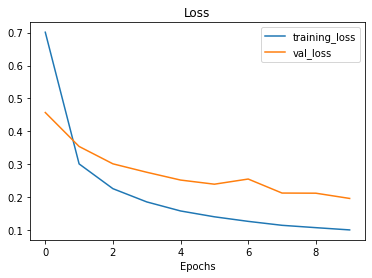

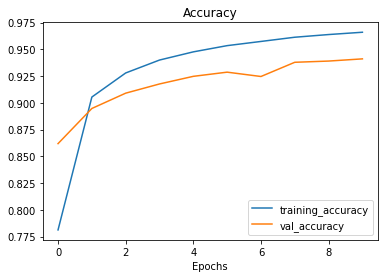

In [43]:
plot_loss_curves(history_6)

## 모델 저장

In [72]:
# #  모델 저장
# model_6.save('/Users/sangjulee1/desktop/HandwrittenCalc_acc_0.9531.H5')

INFO:tensorflow:Assets written to: /Users/sangjulee1/desktop/HandwrittenCalc_acc_0.9531.H5/assets


In [48]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
